Predict future natural gas prices based on historical data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

Data Acquisition

In [ ]:
data = pd.read_csv('/content/NG dataset.csv')

Data Pre-processing

In [ ]:
# Convert 'Date' to datetime and sort by date
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%y')
data = data.sort_values('Date')

# Handle missing values (if any)
data = data.dropna()

Exploratory Data Analysis (EDA)

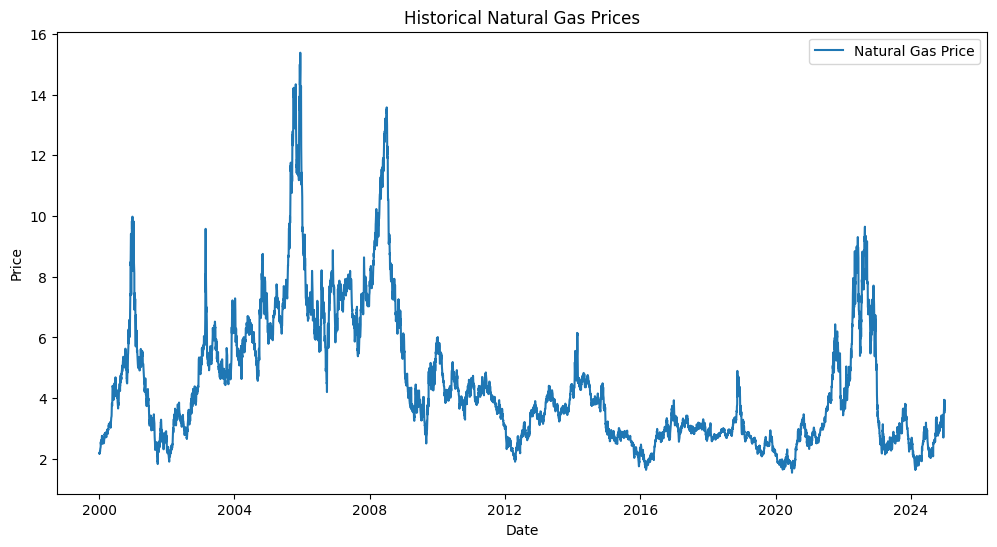

In [ ]:
# Plot historical price trends
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Price'], label='Natural Gas Price')
plt.title('Historical Natural Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Statistical summary
print(data.describe())

                                Date        Price         Open         High  \
count                           6292  6292.000000  6292.000000  6292.000000   
mean   2012-07-16 15:29:38.258105344     4.414400     4.421331     4.522998   
min              2000-01-04 00:00:00     1.544000     1.526000     1.569000   
25%              2006-04-24 18:00:00     2.803000     2.810000     2.857000   
50%              2012-07-23 12:00:00     3.757500     3.764000     3.840500   
75%              2018-10-24 06:00:00     5.543000     5.551250     5.685000   
max              2024-12-31 00:00:00    15.378000    15.160000    15.780000   
std                              NaN     2.208571     2.211952     2.273601   

               Low  
count  6292.000000  
mean      4.315318  
min       1.517000  
25%       2.752000  
50%       3.680000  
75%       5.399500  
max      14.851000  
std       2.148493  


Feature Engineering

In [ ]:
# Extract year, month, and day from the date
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

In [ ]:
# Define features and target
X = data[['Year', 'Month', 'Day']]
y = data['Price']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Selection

In [ ]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

Model Training and Evaluation

In [ ]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse
    print(f"{name} MSE: {mse}")

Linear Regression MSE: 3.704447751231062
Decision Tree MSE: 0.05083586973788722
Random Forest MSE: 0.03678284547410655
SVR MSE: 4.854879974573179
Gradient Boosting MSE: 0.4553907173904181


Hyperparameter Tuning (for the best-performing model)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [ ]:
# Best parameters and MSE
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_
print(f"Best Parameters for Random Forest: {best_params}")
print(f"Best MSE for Random Forest: {best_mse}")

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}
Best MSE for Random Forest: 0.05643483862692585


LSTM Model (Time Series Approach)

In [ ]:
# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Price']].values)

In [ ]:
# Create a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_lstm, y_lstm = create_dataset(scaled_data, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

In [ ]:
# Split the data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

In [ ]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Train the model
lstm_model.fit(X_train_lstm, y_train_lstm, batch_size=1, epochs=1)

4984/4984 ━━━━━━━━━━━━━━━━━━━━ 152s 30ms/step - loss: 0.0013


In [ ]:
# Predict using LSTM
lstm_pred = lstm_model.predict(X_test_lstm)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_lstm = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
lstm_mse = mean_squared_error(y_test_lstm, lstm_pred)
print(f"LSTM MSE: {lstm_mse}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
LSTM MSE: 0.5684122441421888


Predict Future Price

In [ ]:
def predict_future_price(model, year, month, day):
    if model == lstm_model:
        # For LSTM, we need the last `time_step` prices to predict the next price
        last_sequence = scaled_data[-time_step:]  # Use the last `time_step` prices
        last_sequence = last_sequence.reshape((1, time_step, 1))
        predicted_price = model.predict(last_sequence)
        predicted_price = scaler.inverse_transform(predicted_price)
        return predicted_price[0][0]  # LSTM returns a nested array
    else:
        # For other models, use the year, month, and day as features
        future_date = np.array([[year, month, day]])
        predicted_price = model.predict(future_date)
        # Handle scalar output (e.g., Linear Regression, Random Forest)
        if isinstance(predicted_price, np.ndarray) and predicted_price.shape == (1,):
            return predicted_price[0]  # Return the scalar value
        else:
            return predicted_price  # Return as-is

In [ ]:
# Example: Predict the price for a future date
future_year = 2025
future_month = 12
future_day = 31

print(f"Random Forest Predicted Price: {predict_future_price(grid_search.best_estimator_, future_year, future_month, future_day)}")
print(f"LSTM Predicted Price: {predict_future_price(lstm_model, future_year, future_month, future_day)}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Random Forest Predicted Price: 3.6861400000000013
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
LSTM Predicted Price: 4.447455406188965


Visualize Results

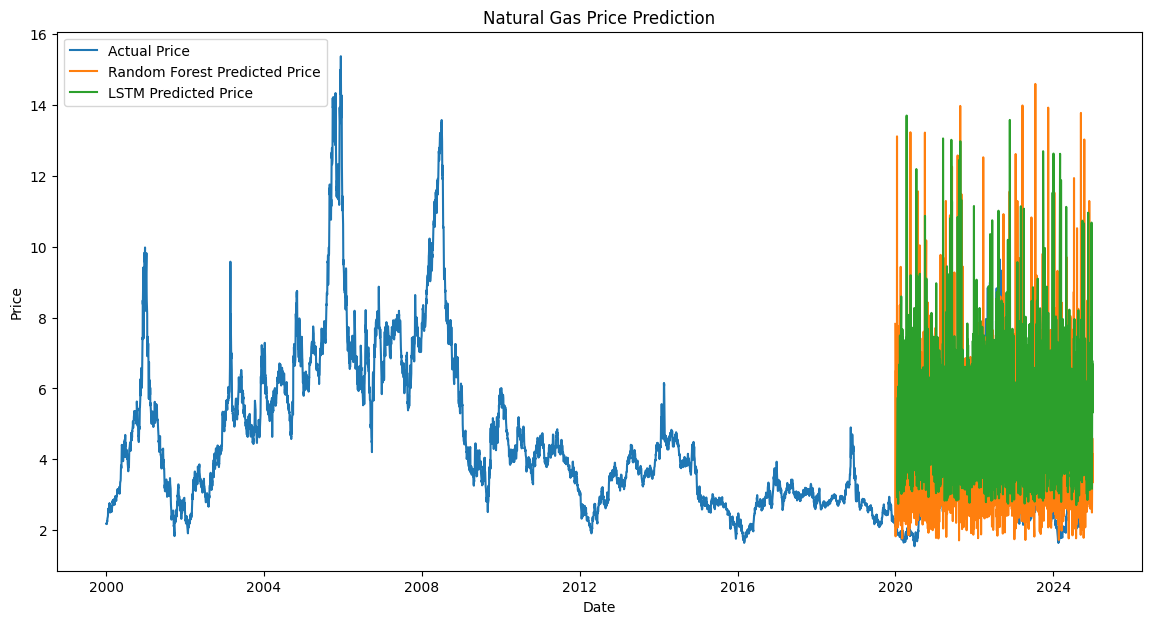

In [ ]:

plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Price'], label='Actual Price')
plt.plot(data['Date'].iloc[-len(y_test):], grid_search.best_estimator_.predict(X_test), label='Random Forest Predicted Price')
plt.plot(data['Date'].iloc[-len(y_test_lstm):], lstm_pred, label='LSTM Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Price Prediction')
plt.legend()
plt.show()
